# Home Credit Default Risk

Risk is an unavoidable part of all human activities and occurs in everyday life. When dealing on financial markets investors are facing to financial risk, which is defined as potential financial loss. Banks encounter many types of risks. As most significant risk is credit risk due to the high exposure of banks in credit transactions. 

An existential problem for any Loan providers is to detect the Loan applicants who are very unlikely to repay the loan. Credit institutions aim to develope credit risk model capable of distinquishing between good and bad loans. Ability to recognise default-prone credit contracts help companies avoid losses and incur huge profits.

##### Paper:        
Master thesis
##### Author:       
Marko Vateha
##### Institution:  
University of Economics and Business in Bratislava

![UEBR](https://euba.sk/www_write/images/cache/3dc4b38399662dd1a15ad970fd72c08e_w1200.jpg)

# Part III. Model development

Model development is an iterative process, in which many models are derived, tested and built upon until a model fitting the desired criteria is built. 

Predictive modelling is often contrasted with causal modelling/analysis. In the former, one may be entirely satisfied to make use of indicators of, or proxies for, the outcome of interest. In the latter, one seeks to determine true cause-and-effect relationships. This distinction has given rise to a burgeoning literature in the fields of research methods and statistics and to the common statement that "correlation does not imply causation".

### 01. First steps

At the beginning we import modules and the the prepared data.

#### 1.1 Importing modules:

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import scipy.stats as stats

from platform import python_version
print(python_version())

3.8.2


#### 1.2 Importing preprocessed data

In [3]:
atrain = pd.read_csv(r'export_17_03_2020.csv', index_col='SK_ID_CURR')
atrain.head()

,TARGET,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FONDKAPREMONT_MODE,HOUSETYPE_MODE,EMERGENCYSTATE_MODE,...,Y_TOTALAREA_MODE,Y_EMERGENCYSTATE_MODE,Y_OCCUPATION_TYPE,Y_EXT_SOURCE_3,Y_AMT_REQ_CREDIT_BUREAU_YEAR,Y_AMT_REQ_CREDIT_BUREAU_QRT,Y_AMT_REQ_CREDIT_BUREAU_HOUR,Y_AMT_REQ_CREDIT_BUREAU_DAY,Y_AMT_REQ_CREDIT_BUREAU_WEEK,Y_AMT_REQ_CREDIT_BUREAU_MON
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1,1,1,1,1,1,1,1,1,1
100003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1,1,1,0,1,1,1,1,1,1
100004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,1,1,1,1,1,1,1
100006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
100007,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0,0,1,0,1,1,1,1,1,1


##### Checking the size of dataset

In [4]:
print(len(atrain), len(atrain.columns))

300433 341


In [5]:
application = pd.read_csv('application_train.csv', index_col='SK_ID_CURR')

In [6]:
print(len(application), len(application.columns))

307511 121


### 02. Preparing data for modelling

#### 2.1 train test split

In preprocessing, the data has been split in order to keep test data untouched. 

As I said before, the data we use is split into training data and test data. The training set contains a known output and the model learns on this data in order to be generalized to other data later on. We have the test dataset (or subset) in order to test our model’s prediction on this subset.

In [7]:
X_train = atrain[atrain.SPLIT=='train'].iloc[:,1:].drop('SPLIT', axis=1).copy()
y_train = atrain[atrain.SPLIT=='train'].iloc[:,0].copy()
X_test = atrain[atrain.SPLIT=='test'].iloc[:,1:].drop('SPLIT', axis=1).copy()
y_test = atrain[atrain.SPLIT=='test'].iloc[:,0].copy()


train_sel = atrain[atrain.SPLIT=='train'].drop('SPLIT', axis=1).copy()
test_sel = atrain[atrain.SPLIT=='test'].drop('SPLIT', axis=1).copy()


X = atrain.iloc[:,1:].drop('SPLIT', axis=1).copy()
y = atrain.iloc[:,0].copy()

##### Continuous and Discrete data

In [8]:
likely_cont = {}
for var in X.columns:
    likely_cont[var] = 1.*X[var].nunique()/X[var].count() > 0.0001
    
col_cont = []  
col_cat = []
for k,v in zip(list(likely_cont.keys()), list(likely_cont.values())):
    if v:
        col_cont.append(k)
    else:
        col_cat.append(k)

#### 2.2 Input scaling

Feature scaling is a method used to normalize the range of independent variables or features of data. In data processing, it is also known as data normalization and is generally performed during the data preprocessing step.

In machine learning, we can handle various types of data, e.g. audio signals and pixel values for image data, and this data can include multiple dimensions. Feature standardization makes the values of each feature in the data have zero-mean (when subtracting the mean in the numerator) and unit-variance. This method is widely used for normalization in many machine learning algorithms (e.g., support vector machines, logistic regression, and artificial neural networks). The general method of calculation is to determine the distribution mean and standard deviation for each feature. Next we subtract the mean from each feature. Then we divide the values (mean is already subtracted) of each feature by its standard deviation.

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train[col_cont] = scaler.fit_transform(X_train[col_cont])
X_test[col_cont] = scaler.transform(X_test[col_cont])

In [9]:
print(len(X_train), len(y_train), len(X_test), len(y_test))

240373 240373 60060 60060


In [10]:
y_train.value_counts(), y_test.value_counts()

(0.0    220808
 1.0     19565
 Name: TARGET, dtype: int64,
 0.0    55162
 1.0     4898
 Name: TARGET, dtype: int64)

##### Defining functions for plotting

In [11]:
def plt_roc(model, name='',png=''):    
    probs = model.predict_proba(X_test)
    # positive outcome only
    probs = probs[:, 1]

    auc = roc_auc_score(y_test, probs)
    print('AUC: %.3f' % auc)

    fpr, tpr, thresholds = roc_curve(y_test, probs)

    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, linestyle='-', label='ROC curve (area = %0.4f)' % auc)
    plt.legend(loc="lower right")
    # labels for axis
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve ' +name)
    
    # SAVE
    if len(png)>0:
        plt.savefig(png)
    
    # show the plot
    plt.show()

In [12]:
def plt_conf(model, name='', png=''):
    ax= plt.subplot()

    cm = confusion_matrix(y_test, model.predict(X_test))
    annot_kws = {"ha": 'center', "va": 'center', "fontsize":22}
    cmap = sns.diverging_palette(10, 133, as_cmap=True)
    sns.heatmap(cm,center=0, annot=True, fmt='.0f', annot_kws=annot_kws, xticklabels=['Splatený', 'Default'], yticklabels=['Splatený', 'Default'], cmap=cmap)
    bottom, top = ax.get_ylim()
    #ax.set_ylim(bottom + 0.5, top - 0.5)
    # labels, title and ticks
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_xlabel('Predpoveď modelu', fontsize=18)
    ax.set_ylabel('Skutočný stav', fontsize=18)
    ax.set_title('Confusion Matrix '+name, fontsize=22, pad=20)
    
    # SAVE
    if len(png)>0:
        plt.savefig(png, bbox_inches='tight')
    
    # show the plt
    plt.show()

### 03. Model development

In this chapter we will biuld a model.

Logistic Regression libraries

In [13]:
import sklearn

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix

Module for storing developed models

In [14]:
import pickle

Methods for metrics we use for determining the best model

In [15]:
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import brier_score_loss
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import matthews_corrcoef

##### Some functions for metrics

In [16]:
def confusion(model):
    tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test)).ravel()
    false_positive_rate = fp / (fp + tn)
    false_negative_rate = fn / (tp + fn)
    true_negative_rate = tn / (tn + fp)
    negative_predictive_value = tn/ (tn + fn)
    false_discovery_rate = fp/ (tp + fp)
    true_positive_rate = tp / (tp + fn)

    print('False positive rate is', false_positive_rate)
    print('False negative rate is', false_negative_rate)
    print('True negative rate is', true_negative_rate)
    print('True positive rate is', true_positive_rate)
    print('False discovery rate is', false_discovery_rate)
    print('Negative predictive value is', negative_predictive_value)
    
    
    rejection_rate = (tp+fp) / (tn + fp + fn + tp)
    print('Rejection rate', rejection_rate )

In [17]:
def metrics(model):
    print('Acc',accuracy_score(y_test, model.predict(X_test)))
    print('F1',f1_score(y_test, model.predict(X_test)))
    print('F2',fbeta_score(y_test, model.predict(X_test), beta=2))
    print('BS',brier_score_loss(y_test, model.predict_proba(X_test)[:,1]))
    print('C-kappa',cohen_kappa_score(y_test, model.predict(X_test)))
    print('matthews',matthews_corrcoef(y_test, model.predict(X_test)))

### A) Dataset without feature selection

In this chapter, we will work with preprocessed data but data without feature selection.

### A) 01. Logistic Regression

##### Training

In [50]:
log_clf = LogisticRegression(penalty='none', solver='saga', class_weight='balanced')
log_clf.fit(X_train, y_train)

print('acc:' ,accuracy_score(y_test, log_clf.predict(X_test)))

acc: 0.69998334998335


##### Storing the model

In [52]:
filename = 'log_clf.sav'
pickle.dump(log_clf, open(filename, 'wb'))

##### Opening saved model

In [18]:
filename = 'models\log_clf.sav'
loaded_log_clf = pickle.load(open(filename, 'rb'))

##### Confusion Matrix

In [16]:
confusion_matrix(y_test, loaded_log_clf.predict(X_test))

array([[38632, 16530],
       [ 1489,  3409]], dtype=int64)

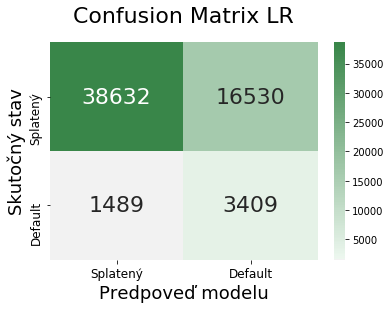

In [196]:
plt_conf(loaded_log_clf, name='LR', png='CM_LR.png')

##### Other Metrics:

In [115]:
confusion(loaded_log_clf)

False positive rate is 0.2996628113556434
False negative rate is 0.30400163331972235
True negative rate is 0.7003371886443566
True positive rate is 0.6959983666802777
False discovery rate is 0.8290285370379658
Negative predictive value is 0.9628872660202886
Rejection rate 0.331984681984682


In [90]:
metrics(loaded_log_clf)

Acc 0.69998334998335
F1 0.2745098039215686
F2 0.4311805924464344
BS 0.19729587623532308
C-kappa 0.16520260369995943
matthews 0.23033231142472965


In [79]:
lr = LogisticRegression(penalty='none', solver='saga')
lr.fit(X_train,y_train)

brier_score_loss(y_test, lr.predict_proba(X_test)[:,1])

0.06793807876812186

##### Alternative metrics:

Precision: 0.1709714629620342
Recall: 0.6959983666802777


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.14')

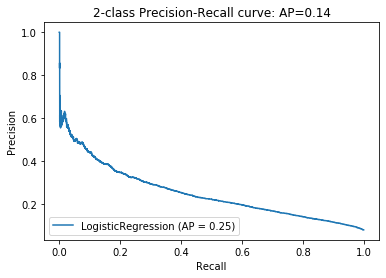

In [34]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print('Precision:',precision_score(y_test,loaded_log_clf.predict(X_test)))
print('Recall:',recall_score(y_test,loaded_log_clf.predict(X_test)))

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

from sklearn.metrics import average_precision_score

average_precision = average_precision_score(y_test, loaded_log_clf.predict(X_test))

disp = plot_precision_recall_curve(loaded_log_clf, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

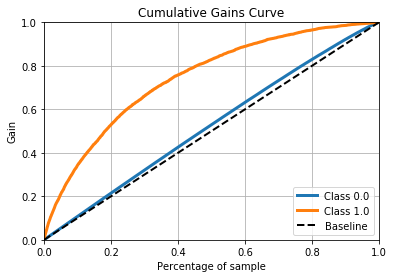

In [35]:
import scikitplot as skplt
y_probas = loaded_log_clf.predict_proba(X_test)
skplt.metrics.plot_cumulative_gain(y_test, y_probas)

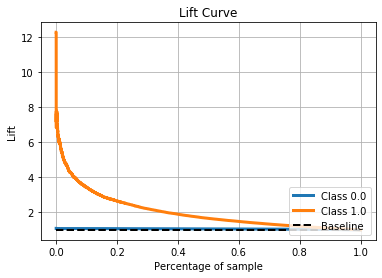

In [36]:
from scikitplot.metrics import plot_lift_curve
fig, ax = plt.subplots()
plot_lift_curve(y_test, y_probas, ax=ax)

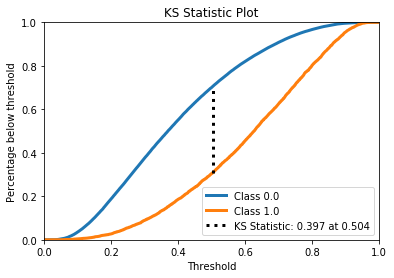

In [37]:
from scikitplot.metrics import plot_ks_statistic
fig, ax = plt.subplots()
plot_ks_statistic(y_test, y_probas, ax=ax)

##### ROC curve

AUC: 0.765


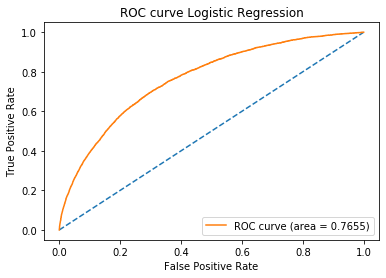

In [42]:
plt_roc(loaded_log_clf, name='Logistic Regression', png='ROC_LR.png')

##### Rentability (managerial point of view)

In [42]:
application = pd.read_csv('application_train.csv', index_col='SK_ID_CURR')

test_credit = application.loc[X_test.index, ['AMT_CREDIT', 'TARGET']]
test_credit['Pred'] = loaded_log_clf.predict(X_test)
print(test_credit.groupby('TARGET').sum().iloc[1,0]/test_credit.groupby('TARGET').sum().iloc[0,0])
print(test_credit[test_credit.Pred==0].groupby('TARGET').sum().iloc[1,0]/test_credit[test_credit.Pred==0].groupby('TARGET').sum().iloc[0,0])

0.08191553464739985
0.03761093347862277


In [43]:
test_credit.groupby('TARGET').sum()

,AMT_CREDIT,Pred
TARGET,,
0,3.284396e+10,16530.0
1,2.690431e+09,3409.0


In [44]:
test_credit[test_credit.Pred==0].groupby('TARGET').sum()

,AMT_CREDIT,Pred
TARGET,,
0,2.340009e+10,0.0
1,8.800992e+08,0.0


### A) 02. Ridge regularization

##### Training

In [16]:
from sklearn.linear_model import LogisticRegressionCV

ridge = LogisticRegressionCV(Cs = [0.01,0.005,0.001], cv=3, penalty = "l2", solver = "saga", class_weight='balanced', scoring = "roc_auc")
ridge.fit(X_train, y_train)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, ridge.predict(X_test))

# 22 m 17s

array([[38652, 16510],
       [ 1499,  3399]], dtype=int64)

##### Storing the model

In [ ]:
filename = 'ridge.sav'
pickle.dump(ridge, open(filename, 'wb'))

##### Loading

In [20]:
filename = 'ridge.sav'
loaded_ridge = pickle.load(open(filename, 'rb'))

In [62]:
loaded_ridge.C_

array([0.01])

##### Confusion Matrix:

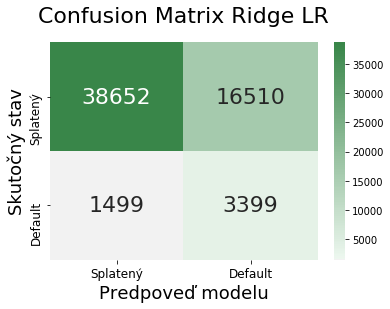

In [193]:
plt_conf(loaded_ridge, name='Ridge LR', png='CM_R_LR.png')

##### ROC curve

AUC: 0.766


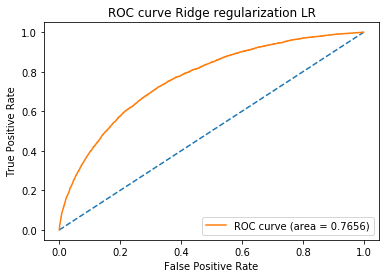

In [46]:
plt_roc(loaded_ridge, name='Ridge regularization LR', png='ROC_R_LR.png')

##### Other Metrics

In [116]:
confusion(loaded_ridge)

False positive rate is 0.29930024292085133
False negative rate is 0.3060432829726419
True negative rate is 0.7006997570791487
True positive rate is 0.6939567170273581
False discovery rate is 0.8292731930282786
Negative predictive value is 0.9626659360912555
Rejection rate 0.33148518148518147


In [91]:
metrics(loaded_ridge)

Acc 0.7001498501498501
F1 0.27403555448059014
F2 0.4302422723475354
BS 0.19736815193565654
C-kappa 0.16469428805447417
matthews 0.22944347811308483


In [78]:
ridge_lr = LogisticRegression(penalty='l2', C=0.01, solver='saga')
ridge_lr.fit(X_train,y_train)

brier_score_loss(y_test, ridge_lr.predict_proba(X_test)[:,1])

0.0679600527013463

##### Rentability (managerial point of view)

In [81]:
test_credit = application.loc[X_test.index, ['AMT_CREDIT', 'TARGET']]
test_credit['Pred'] = loaded_ridge.predict(X_test)
print(test_credit.groupby('TARGET').sum().iloc[1,0]/test_credit.groupby('TARGET').sum().iloc[0,0])
print(test_credit[test_credit.Pred==0].groupby('TARGET').sum().iloc[1,0]/test_credit[test_credit.Pred==0].groupby('TARGET').sum().iloc[0,0])

test_credit[test_credit.Pred==0].groupby('TARGET').sum()

0.08191553464739985
0.03797731181757704


,AMT_CREDIT,Pred
TARGET,,
0,2.342465e+10,0.0
1,8.896052e+08,0.0


### A) 03. Lasso Regularization

##### Train

In [19]:
from sklearn.linear_model import LogisticRegressionCV

lasso = LogisticRegressionCV(Cs = [0.1,0.01,0.005], cv=3, penalty = "l1", solver = "saga", class_weight='balanced', scoring = "roc_auc")
lasso.fit(X_train, y_train)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, lasso.predict(X_test))

# 36m 31s

array([[38650, 16512],
       [ 1504,  3394]], dtype=int64)

##### Storing the model

In [ ]:
filename = 'lasso.sav'
pickle.dump(lasso, open(filename, 'wb'))

##### Loading

In [21]:
filename = 'models\lasso.sav'
loaded_lasso = pickle.load(open(filename, 'rb'))

In [75]:
loaded_lasso.C_

array([0.1])

##### Confusion Matrix

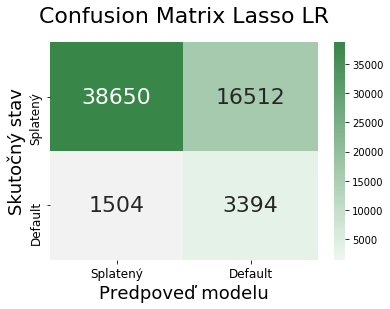

In [194]:
plt_conf(loaded_lasso, name='Lasso LR', png='CM_L_LR.png')

##### ROC curve

AUC: 0.766


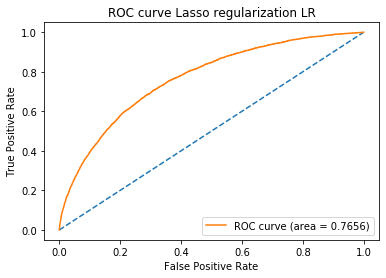

In [48]:
plt_roc(loaded_lasso, name='Lasso regularization LR', png='ROC_L_LR.png')

##### Other Metrics

In [117]:
confusion(loaded_lasso)

False positive rate is 0.2993364997643305
False negative rate is 0.30706410779910165
True negative rate is 0.7006635002356695
True positive rate is 0.6929358922008984
False discovery rate is 0.8294986436250377
Negative predictive value is 0.9625442048114758
Rejection rate 0.33143523143523146


In [92]:
metrics(loaded_lasso)

Acc 0.7000333000333
F1 0.27366553781648123
F2 0.4296420071902375
BS 0.19733105465761278
C-kappa 0.16427228669982175
matthews 0.2288376106529787


In [77]:
lasso_lr = LogisticRegression(penalty='l1', C=0.1, solver='saga')
lasso_lr.fit(X_train,y_train)

brier_score_loss(y_test, lasso_lr.predict_proba(X_test)[:,1])

0.0679366715977513

##### Rentability (managerial point of view)

In [82]:
test_credit = application.loc[X_test.index, ['AMT_CREDIT', 'TARGET']]
test_credit['Pred'] = loaded_lasso.predict(X_test)
print(test_credit.groupby('TARGET').sum().iloc[1,0]/test_credit.groupby('TARGET').sum().iloc[0,0])
print(test_credit[test_credit.Pred==0].groupby('TARGET').sum().iloc[1,0]/test_credit[test_credit.Pred==0].groupby('TARGET').sum().iloc[0,0])

test_credit[test_credit.Pred==0].groupby('TARGET').sum()

0.08191553464739985
0.03794329819141588


,AMT_CREDIT,Pred
TARGET,,
0,2.341650e+10,0.0
1,8.884994e+08,0.0


### A) 04. Elastic-net Regularization

##### Train

In [79]:
from sklearn.model_selection import GridSearchCV
el = LogisticRegression(penalty='elasticnet', solver='saga', class_weight='balanced')

parameters = {'l1_ratio':[0.6,0.5,0.4], 'C':[0.1,0.01,0.005]}

el_clf = GridSearchCV(el, parameters, cv=3, scoring='roc_auc')
el_clf.fit(X_train, y_train)

print('acc:' ,accuracy_score(y_test, el_clf.predict(X_test)))

# 0.01 a 0.4
# 2h 5m 40s

acc: 0.6988011988011988


##### Storing the model

In [ ]:
filename = 'el_clf.sav'
pickle.dump(el_clf, open(filename, 'wb'))

##### Loading

In [23]:
filename = 'models\el_clf.sav'
loaded_el = pickle.load(open(filename, 'rb'))

In [209]:
loaded_el.predict(X_test)

array([1., 0., 0., ..., 0., 0., 1.])

In [24]:
loaded_el.best_estimator_

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=0.4,
                   max_iter=100, multi_class='auto', n_jobs=None,
                   penalty='elasticnet', random_state=None, solver='saga',
                   tol=0.0001, verbose=0, warm_start=False)

##### Confusion Matrix

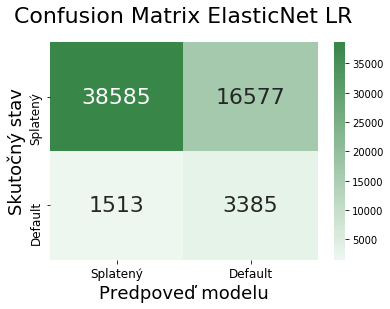

In [195]:
plt_conf(loaded_el, name='ElasticNet LR', png='CM_El_LR.png')

##### ROC curve

AUC: 0.766


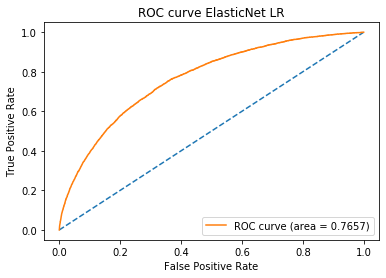

In [50]:
plt_roc(loaded_el, name='ElasticNet LR', png='ROC_El_LR.png')

##### Other Metrics

In [118]:
confusion(loaded_el)

False positive rate is 0.30051484717740473
False negative rate is 0.30890159248672927
True negative rate is 0.6994851528225953
True positive rate is 0.6910984075132707
False discovery rate is 0.8304278128444044
Negative predictive value is 0.9622674447603372
Rejection rate 0.3323676323676324


In [100]:
metrics(loaded_el)

Acc 0.6988011988011988
F1 0.2723250201126307
F2 0.42789604085553923
BS 0.19762354289419964
C-kappa 0.16265997355335626
matthews 0.22692375994394043


In [76]:
el_lr = LogisticRegression(penalty='elasticnet', C=0.01, solver='saga', l1_ratio=0.4)
el_lr.fit(X_train,y_train)

brier_score_loss(y_test, el_lr.predict_proba(X_test)[:,1])

0.06800521203820122

##### Rentability (managerial point of view)

In [83]:
test_credit = application.loc[X_test.index, ['AMT_CREDIT', 'TARGET']]
test_credit['Pred'] = loaded_el.predict(X_test)
print(test_credit.groupby('TARGET').sum().iloc[1,0]/test_credit.groupby('TARGET').sum().iloc[0,0])
print(test_credit[test_credit.Pred==0].groupby('TARGET').sum().iloc[1,0]/test_credit[test_credit.Pred==0].groupby('TARGET').sum().iloc[0,0])

test_credit[test_credit.Pred==0].groupby('TARGET').sum()

0.08191553464739985
0.03845722271545594


,AMT_CREDIT,Pred
TARGET,,
0,2.338200e+10,0.0
1,8.992067e+08,0.0


### A) 05. SVM non-regularized

Importing modules for training

In [87]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV

##### Training

In [217]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

svc_base = LinearSVC(dual=False)
nreg_svc = CalibratedClassifierCV(base_estimator=svc_base, cv=3)
nreg_svc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

##### Storing the model

In [63]:
import pickle

filename = 'non_reg_svc.sav'
pickle.dump(nreg_svc, open(filename, 'wb'))

##### Loading

In [105]:
filename = 'non_reg_svc.sav'
loaded_nreg_svc = pickle.load(open(filename, 'rb'))

In [106]:
loaded_nreg_svc.predict(X_test)

array([0., 0., 0., ..., 0., 0., 0.])

##### Kolmogorov–Smirnov test

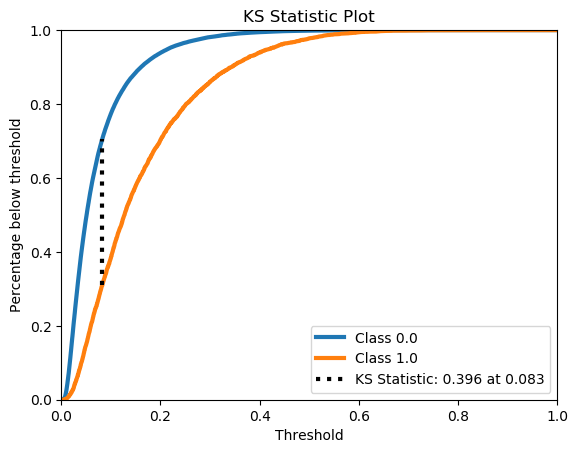

In [107]:
from scikitplot.metrics import plot_ks_statistic
fig, ax = plt.subplots()
y_probas = loaded_nreg_svc.predict_proba(X_test)
plot_ks_statistic(y_test, y_probas, ax=ax)

In [109]:
# with new threshold
threshold = 0.083
y_pred_threshold_1 = (loaded_nreg_svc.predict_proba(X_test)[:, 1] >= threshold).astype(bool)

confusion_matrix(y_test, y_pred_threshold_1)

array([[39014, 16148],
       [ 1527,  3371]], dtype=int64)

##### ROC curve

AUC: 0.7647


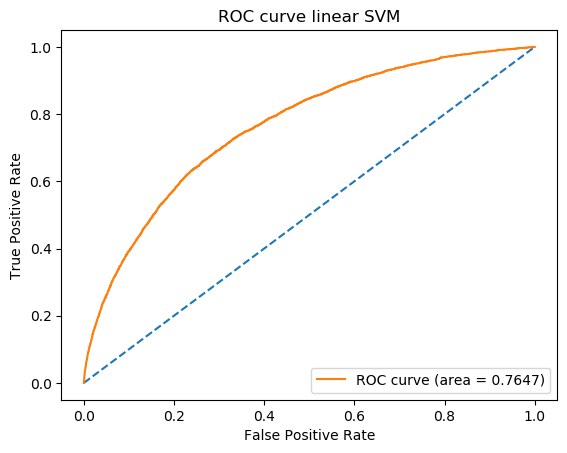

In [110]:
probs = loaded_nreg_svc.predict_proba(X_test)[:, 1]
# positive outcome only

auc = roc_auc_score(y_test, probs)
print('AUC: %.4f' % auc)

fpr, tpr, thresholds = roc_curve(y_test, probs)

plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, linestyle='-', label='ROC curve (area = %0.4f)' % auc)
plt.legend(loc="lower right")
# labels for axis
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve linear SVM')

plt.savefig('ROC_nonreg_SVC')
# show the plot
plt.show()

##### Confusion Matrix

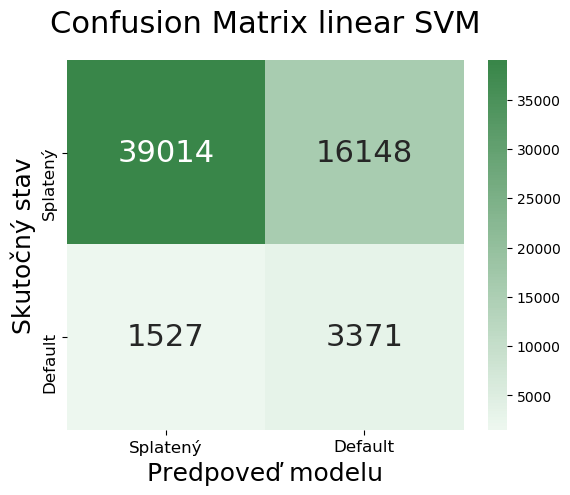

In [111]:
cm = confusion_matrix(y_test, y_pred_threshold_1)
ax= plt.subplot()
annot_kws = {"ha": 'center', "va": 'center', 'ma': 'center', 'fontsize':22}
cmap = sns.diverging_palette(10, 133, as_cmap=True)
sns.heatmap(cm,center=0, annot=True, fmt='.0f', annot_kws=annot_kws, xticklabels=['Splatený', 'Default'], yticklabels=['Splatený', 'Default'], cmap=cmap)
# bottom, top = ax.get_ylim()
#ax.set_ylim(bottom + 0.5, top - 0.5)
# labels, title and ticks
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_xlabel('Predpoveď modelu', fontsize=18)
ax.set_ylabel('Skutočný stav', fontsize=18)
ax.set_title('Confusion Matrix linear SVM', fontsize=22, pad=20)


# SAVE
plt.savefig('CM_nonreg_SVM_lin.png', bbox_inches='tight')
plt.show()

##### Other metrics

In [112]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_threshold_1).ravel()
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (tp + fn)
true_negative_rate = tn / (tn + fp)
negative_predictive_value = tn/ (tn + fn)
false_discovery_rate = fp/ (tp + fp)
true_positive_rate = tp / (tp + fn)

print('False positive rate is', false_positive_rate)
print('False negative rate is', false_negative_rate)
print('True negative rate is', true_negative_rate)
print('True positive rate is', true_positive_rate)
print('False discovery rate is', false_discovery_rate)
print('Negative predictive value is', negative_predictive_value)

rejection_rate = (tp+fp) / (tn + fp + fn + tp)
print('Rejection rate', rejection_rate )

False positive rate is 0.2927377542511149
False negative rate is 0.31175990200081666
True negative rate is 0.7072622457488851
True positive rate is 0.6882400979991833
False discovery rate is 0.827296480352477
Negative predictive value is 0.9623344268764954
Rejection rate 0.324991674991675


In [113]:
print('Acc',accuracy_score(y_test, y_pred_threshold_1))
print('F1',f1_score(y_test, y_pred_threshold_1))
print('F2',fbeta_score(y_test, y_pred_threshold_1, beta=2))
print('BS',brier_score_loss(y_test, loaded_nreg_svc.predict_proba(X_test)[:,1]))
print('C-kappa',cohen_kappa_score(y_test, y_pred_threshold_1))
print('matthews',matthews_corrcoef(y_test, y_pred_threshold_1))

Acc 0.7057109557109557
F1 0.2761190973502068
F2 0.43095292884354786
BS 0.06800640123992177
C-kappa 0.16758430790233658
matthews 0.23110132917223902


In [93]:
unique, counts = np.unique(y_pred_threshold, return_counts=True)

np.asarray((unique, counts)).T

array([[    0, 40541],
       [    1, 19519]], dtype=int64)

##### Rentability (managerial point of view)

In [113]:
test_credit = application.loc[X_test.index, ['AMT_CREDIT', 'TARGET']].copy()
test_credit['Pred'] = y_pred_threshold_1
print(test_credit.groupby('TARGET').sum().iloc[1,0]/test_credit.groupby('TARGET').sum().iloc[0,0])
print(test_credit[test_credit.Pred==0].groupby('TARGET').sum().iloc[1,0]/test_credit[test_credit.Pred==0].groupby('TARGET').sum().iloc[0,0])

test_credit[test_credit.Pred==0].groupby('TARGET').sum()

0.08191553464739985
0.03837624935556427


,AMT_CREDIT,Pred
TARGET,,
0,2.373881e+10,False
1,9.110065e+08,False


### A) 06. SVM regularized

##### Training

In [103]:
from sklearn.model_selection import GridSearchCV
svc_base = LinearSVC(class_weight='balanced')

# 'loss':['hinge','squared_hinge'], 
parameters = {'penalty':['l1','l2'], 'C':[0.1,0.01,0.005]}

svc_lin = GridSearchCV(svc_base, parameters, cv=3, scoring='f1_weighted')
svc_lin.fit(X_train, y_train)

print('acc:' ,accuracy_score(y_test, svc_lin.predict(X_test)))


acc: 0.7025141525141525


##### Storing the model

In [104]:
import pickle

filename = 'svc_linear.sav'
pickle.dump(svc_lin, open(filename, 'wb'))

##### Loading

In [106]:
filename = 'models\svc_linear.sav'
loaded_svc = pickle.load(open(filename, 'rb'))

In [215]:
loaded_svc.predict(X_test)

array([0., 0., 0., ..., 0., 0., 0.])

In [108]:
loaded_svc.best_estimator_

LinearSVC(C=0.1, class_weight='balanced', dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

##### Calibrating trained model the get probability

In [110]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

svc_base = LinearSVC(C=0.1, penalty='l2', class_weight='balanced', dual=False)
c_svc = CalibratedClassifierCV(base_estimator=svc_base, cv=3)
c_svc.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=LinearSVC(C=0.1, class_weight='balanced',
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                loss='squared_hinge',
                                                max_iter=1000,
                                                multi_class='ovr', penalty='l2',
                                                random_state=None, tol=0.0001,
                                                verbose=0),
                       cv=3, method='sigmoid')

In [111]:
filename = 'calibrated_svc.sav'
pickle.dump(c_svc, open(filename, 'wb'))

In [18]:
filename = 'models\calibrated_svc.sav'
loaded_svc = pickle.load(open(filename, 'rb'))

##### ROC curve

AUC: 0.766


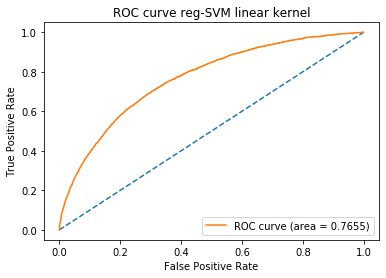

In [19]:
plt_roc(loaded_svc, name='reg-SVM linear kernel', png='ROC_SVM_Lin.png')

##### Kolmogorov–Smirnov test

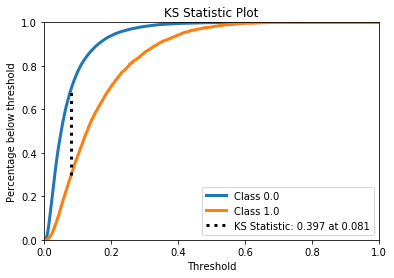

In [23]:
from scikitplot.metrics import plot_ks_statistic
fig, ax = plt.subplots()
y_probas = loaded_svc.predict_proba(X_test)
plot_ks_statistic(y_test, y_probas, ax=ax)
plt.savefig('KS statistic reg_SVM.png')

In [105]:
# with new threshold
threshold = 0.081
y_pred_threshold = (loaded_svc.predict_proba(X_test)[:, 1] >= threshold).astype(bool)

confusion_matrix(y_test, y_pred_threshold)

array([[38337, 16825],
       [ 1461,  3437]], dtype=int64)

AUC: 0.7655


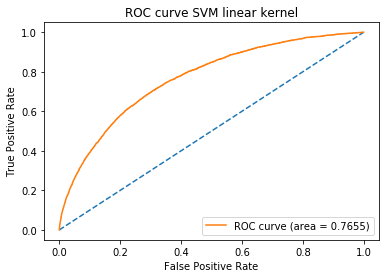

In [26]:
probs = loaded_svc.predict_proba(X_test)[:, 1]
# positive outcome only

auc = roc_auc_score(y_test, probs)
print('AUC: %.4f' % auc)

fpr, tpr, thresholds = roc_curve(y_test, probs)

plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, linestyle='-', label='ROC curve (area = %0.4f)' % auc)
plt.legend(loc="lower right")
# labels for axis
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve SVM linear kernel')

plt.savefig('ROC_reg_SVM.png')
# show the plot
plt.show()

##### Confusion Matrix

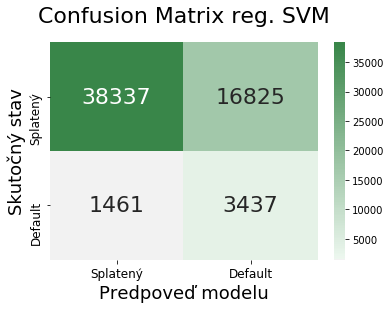

In [184]:
cm = confusion_matrix(y_test, y_pred_threshold)
ax= plt.subplot()
annot_kws = {"ha": 'center', "va": 'center', 'ma': 'center', 'fontsize':22}
cmap = sns.diverging_palette(10, 133, as_cmap=True)
sns.heatmap(cm,center=0, annot=True, fmt='.0f', annot_kws=annot_kws, xticklabels=['Splatený', 'Default'], yticklabels=['Splatený', 'Default'], cmap=cmap)
# bottom, top = ax.get_ylim()
#ax.set_ylim(bottom + 0.5, top - 0.5)
# labels, title and ticks
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_xlabel('Predpoveď modelu', fontsize=18)
ax.set_ylabel('Skutočný stav', fontsize=18)
ax.set_title('Confusion Matrix reg. SVM', fontsize=22, pad=20)

# SAVE
plt.savefig('CM_SVM_lin.png', bbox_inches='tight')
plt.show()

##### Other Metrics

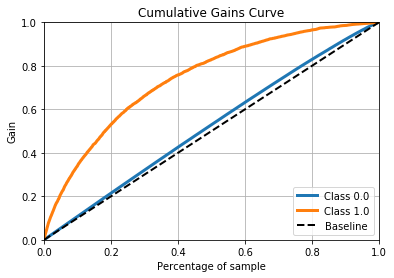

In [24]:
import scikitplot as skplt
y_probas = loaded_svc.predict_proba(X_test)
skplt.metrics.plot_cumulative_gain(y_test, y_probas)
plt.savefig('Cumulative gains reg-SVM.png')

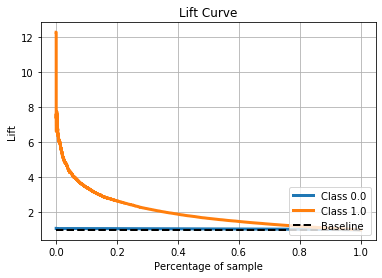

In [25]:
from scikitplot.metrics import plot_lift_curve
fig, ax = plt.subplots()
plot_lift_curve(y_test, y_probas, ax=ax)
plt.savefig('Lif curve reg_SVM.png')

In [108]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_threshold).ravel()
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (tp + fn)
true_negative_rate = tn / (tn + fp)
negative_predictive_value = tn/ (tn + fn)
false_discovery_rate = fp/ (tp + fp)
true_positive_rate = tp / (tp + fn)
rejection_rate = (tp+fp) / (tn + fp + fn + tp)

print('False positive rate is', false_positive_rate)
print('False negative rate is', false_negative_rate)
print('True negative rate is', true_negative_rate)
print('True positive rate is', true_positive_rate)
print('False discovery rate is', false_discovery_rate)
print('Negative predictive value is', negative_predictive_value)
print('Rejection rate', rejection_rate )

False positive rate is 0.3050106957688264
False negative rate is 0.2982850142915476
True negative rate is 0.6949893042311737
True positive rate is 0.7017149857084525
False discovery rate is 0.8303721251603988
Negative predictive value is 0.9632896125433439
Rejection rate 0.3373626373626374


In [96]:
print('Acc',accuracy_score(y_test, y_pred_threshold))
print('F1',f1_score(y_test, y_pred_threshold))
print('F2',fbeta_score(y_test, y_pred_threshold, beta=2))
print('BS',brier_score_loss(y_test, loaded_svc.predict_proba(X_test)[:,1]))
print('C-kappa',cohen_kappa_score(y_test, y_pred_threshold))
print('matthews',matthews_corrcoef(y_test, y_pred_threshold))

Acc 0.6955377955377955
F1 0.2732114467408585
F2 0.4311988758970242
BS 0.06798328076154085
C-kappa 0.16331108030338337
matthews 0.22962782377754323


##### Rentability (managerial point of view)

In [97]:
test_credit = application.loc[X_test.index, ['AMT_CREDIT', 'TARGET']].copy()
test_credit['Pred'] = y_pred_threshold
print(test_credit.groupby('TARGET').sum().iloc[1,0]/test_credit.groupby('TARGET').sum().iloc[0,0])
print(test_credit[test_credit.Pred==0].groupby('TARGET').sum().iloc[1,0]/test_credit[test_credit.Pred==0].groupby('TARGET').sum().iloc[0,0])

test_credit[test_credit.Pred==0].groupby('TARGET').sum()

0.08191553464739985
0.03741561809468299


,AMT_CREDIT,Pred
TARGET,,
0,2.324163e+10,False
1,8.696000e+08,False


## B) Dataset after feature selection

#### Adjusted functions

In [41]:
def plt_roc(model, name='',png=''):    
    probs = model.predict_proba(X_test_1)
    # positive outcome only
    probs = probs[:, 1]

    auc = roc_auc_score(y_test, probs)
    print('AUC: %.3f' % auc)

    fpr, tpr, thresholds = roc_curve(y_test_1, probs)

    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, linestyle='-', label='ROC curve (area = %0.4f)' % auc)
    plt.legend(loc="lower right")
    # labels for axis
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve ' +name)
    
    # SAVE
    if len(png)>0:
        plt.savefig(png+'_1')
    
    # show the plot
    plt.show()

In [42]:
def plt_conf(model, name='', png=''):
    ax= plt.subplot()

    cm = confusion_matrix(y_test, model.predict(X_test_1))
    annot_kws = {"ha": 'center', "va": 'center', "fontsize":22}
    cmap = sns.diverging_palette(10, 133, as_cmap=True)
    sns.heatmap(cm,center=0, annot=True, fmt='.0f', annot_kws=annot_kws, xticklabels=['Splatený', 'Default'], yticklabels=['Splatený', 'Default'], cmap=cmap)
    bottom, top = ax.get_ylim()
    #ax.set_ylim(bottom + 0.5, top - 0.5)
    # labels, title and ticks
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_xlabel('Predpoveď modelu', fontsize=18)
    ax.set_ylabel('Skutočný stav', fontsize=18)
    ax.set_title('Confusion Matrix '+name, fontsize=22, pad=20)
    
    # SAVE
    if len(png)>0:
        plt.savefig(png+'_1', bbox_inches='tight')
    
    # show the plt
    plt.show()

In [39]:
def confusion(model):
    tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test_1)).ravel()
    false_positive_rate = fp / (fp + tn)
    false_negative_rate = fn / (tp + fn)
    true_negative_rate = tn / (tn + fp)
    negative_predictive_value = tn/ (tn + fn)
    false_discovery_rate = fp/ (tp + fp)
    true_positive_rate = tp / (tp + fn)

    print('False positive rate is', false_positive_rate)
    print('False negative rate is', false_negative_rate)
    print('True negative rate is', true_negative_rate)
    print('True positive rate is', true_positive_rate)
    print('False discovery rate is', false_discovery_rate)
    print('Negative predictive value is', negative_predictive_value)
    
    
    rejection_rate = (tp+fp) / (tn + fp + fn + tp)
    print('Rejection rate', rejection_rate )

In [40]:
def metrics(model):
    print('Acc',accuracy_score(y_test, model.predict(X_test_1)))
    print('F1',f1_score(y_test, model.predict(X_test_1)))
    print('F2',fbeta_score(y_test, model.predict(X_test_1), beta=2))
    print('C-kappa',cohen_kappa_score(y_test, model.predict(X_test_1)))
    print('matthews',matthews_corrcoef(y_test, model.predict(X_test_1)))

### B) 01. Logistic regression

Reading prepared files

In [ ]:
X_train_1 = pd.read_csv('X_train_1.csv')
X_test_1 = pd.read_csv('X_test_1.csv')
y_train_1 = pd.read_csv('y_train_1.csv')
y_test_1= pd.read_csv('y_test_1.csv')

In [69]:
plt.style.use('default')

##### Training

In [58]:
log_clf1 = LogisticRegression(penalty='none', solver='saga', class_weight='balanced')
log_clf1.fit(X_train_1, y_train_1)

print('acc:' ,accuracy_score(y_test_1, log_clf1.predict(X_test_1)))

acc: 0.6993839493839494


In [160]:
log_clf1.predict(X_test_1)

array([1., 0., 0., ..., 0., 0., 1.])

##### Saving the model

In [50]:
import pickle

filename = 'log_clf1.sav'
pickle.dump(log_clf1, open(filename, 'wb'))

##### Loading

In [53]:
filename = 'models\log_clf1.sav'
loaded_log_clf1 = pickle.load(open(filename, 'rb'))

##### Confusion Matrix

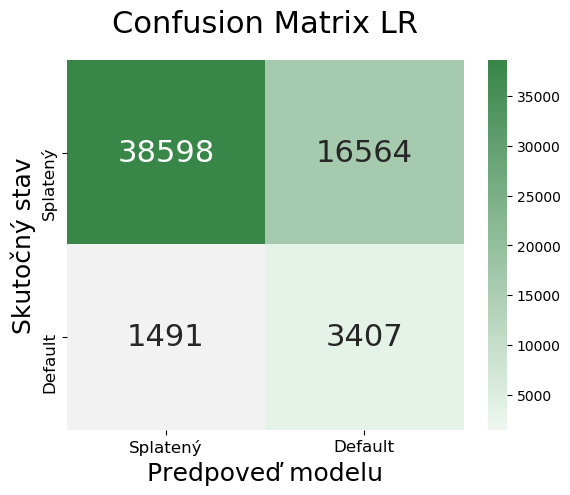

In [146]:
plt_conf(loaded_log_clf1, 'LR', png='CM_LR_1.png')

##### ROC curve

AUC: 0.765


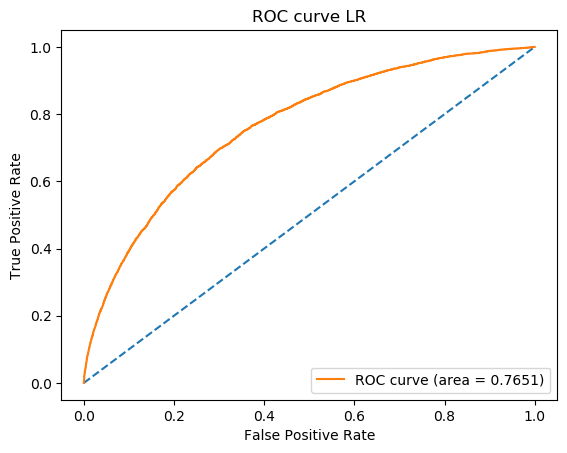

In [148]:
plt_roc(loaded_log_clf1, 'LR', png='ROC_LR_1.png')

##### Other Metrics

In [56]:
confusion(loaded_log_clf1)

False positive rate is 0.3002791776947899
False negative rate is 0.3044099632503062
True negative rate is 0.6997208223052102
True positive rate is 0.6955900367496938
False discovery rate is 0.8294026338190376
Negative predictive value is 0.962807752750131
Rejection rate 0.33251748251748253


In [57]:
metrics(loaded_log_clf1)

Acc 0.6993839493839494
F1 0.2739957376653665
F2 0.4305790764097767
C-kappa 0.16457129847551843
matthews 0.22964427309857333


In [49]:
lr_1 = LogisticRegression(penalty='none', solver='saga')
lr_1.fit(X_train_1,y_train_1)

brier_score_loss(y_test_1, lr_1.predict_proba(X_test_1)[:,1])

0.0679393071233594

##### Rentability (managerial point of view)

In [91]:
test_credit = application.loc[X_test.index, ['AMT_CREDIT', 'TARGET']]
test_credit['Pred'] = loaded_log_clf1.predict(X_test_1)
print(test_credit.groupby('TARGET').sum().iloc[1,0]/test_credit.groupby('TARGET').sum().iloc[0,0])
print(test_credit[test_credit.Pred==0].groupby('TARGET').sum().iloc[1,0]/test_credit[test_credit.Pred==0].groupby('TARGET').sum().iloc[0,0])

test_credit[test_credit.Pred==0].groupby('TARGET').sum()

0.08191553464739985
0.037995511442303925


,AMT_CREDIT,Pred
TARGET,,
0,2.340327e+10,0.0
1,8.892193e+08,0.0


### B) 02. Ridge Regularization

##### Training

In [76]:
from sklearn.linear_model import LogisticRegressionCV

ridge_clf1 = LogisticRegressionCV(Cs = [0.1,0.01,0.005], cv=3, penalty = "l2", solver = "saga", class_weight='balanced', scoring = "roc_auc")
ridge_clf1.fit(X_train_1, y_train_1)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_1, ridge_clf1.predict(X_test_1))

# 9m 6s

array([[38614, 16548],
       [ 1490,  3408]], dtype=int64)

In [161]:
ridge_clf1.predict(X_test_1)

array([1., 0., 0., ..., 0., 0., 1.])

##### Storing the model

In [60]:
import pickle

filename = 'ridge_clf1.sav'
pickle.dump(ridge_clf1, open(filename, 'wb'))

##### Loading

In [64]:
filename = 'ridge_clf1.sav'
loaded_ridge_clf1 = pickle.load(open(filename, 'rb'))

In [65]:
loaded_ridge_clf1.C_

array([0.1])

##### Confusion Matrix

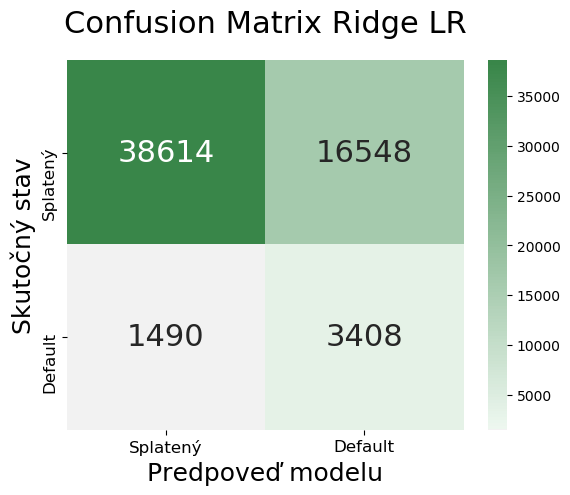

In [150]:
plt_conf(loaded_ridge_clf1, 'Ridge LR', png='CM_l2LR_1.png')

##### ROC curve

AUC: 0.765


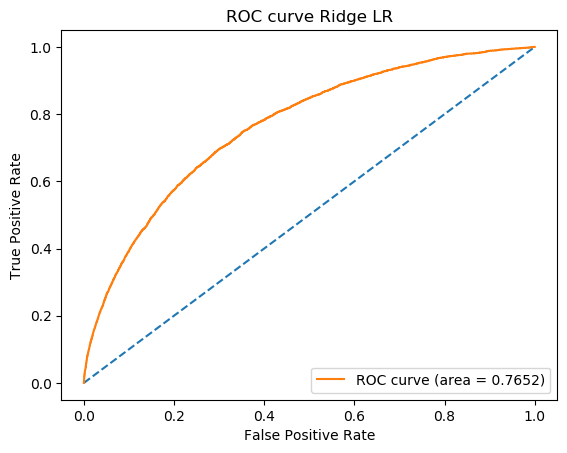

In [151]:
plt_roc(loaded_ridge_clf1, 'Ridge LR', png='ROC_l2LR_1.png')

##### Other Metrics

In [73]:
confusion(loaded_ridge_clf_1)

False positive rate is 0.29998912294695623
False negative rate is 0.3042057982850143
True negative rate is 0.7000108770530438
True positive rate is 0.6957942017149857
False discovery rate is 0.8292242934455802
Negative predictive value is 0.9628465988430082
Rejection rate 0.33226773226773226


In [74]:
metrics(loaded_ridge_clf_1)

Acc 0.6996669996669996
F1 0.2742415707733162
F2 0.4308688176393244
C-kappa 0.16487281515212804
matthews 0.22997475320781333


In [75]:
ridge_1 = LogisticRegression(C=0.1, solver='saga')
ridge_1.fit(X_train_1,y_train_1)

brier_score_loss(y_test_1, ridge_1.predict_proba(X_test_1)[:,1])

0.06793664926225303

##### Rentability (managerial point of view)

In [89]:
test_credit = application.loc[X_test.index, ['AMT_CREDIT', 'TARGET']]
test_credit['Pred'] = loaded_ridge_clf1.predict(X_test_1)
print(test_credit.groupby('TARGET').sum().iloc[1,0]/test_credit.groupby('TARGET').sum().iloc[0,0])
print(test_credit[test_credit.Pred==0].groupby('TARGET').sum().iloc[1,0]/test_credit[test_credit.Pred==0].groupby('TARGET').sum().iloc[0,0])

test_credit[test_credit.Pred==0].groupby('TARGET').sum()

0.08191553464739985
0.037965723879970964


,AMT_CREDIT,Pred
TARGET,,
0,2.341652e+10,0.0
1,8.890250e+08,0.0


### B) 03. Lasso Regularization

##### Training

In [78]:
from sklearn.linear_model import LogisticRegressionCV

lasso_clf1 = LogisticRegressionCV(Cs = [0.1,0.01,0.005], cv=3, penalty = "l1", solver = "saga", class_weight='balanced', scoring = "roc_auc")
lasso_clf1.fit(X_train_1, y_train_1)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_1, lasso_clf1.predict(X_test_1))

# time 11m 5

array([[38611, 16551],
       [ 1489,  3409]], dtype=int64)

In [162]:
lasso_clf1.predict(X_test_1)

array([1., 0., 0., ..., 0., 0., 1.])

##### Storing the model

In [79]:
import pickle

filename = 'lasso_clf1.sav'
pickle.dump(lasso_clf1, open(filename, 'wb'))

##### Loading

In [80]:
filename = 'lasso_clf1.sav'
loaded_lasso_clf1 = pickle.load(open(filename, 'rb'))

In [81]:
loaded_lasso_clf1.C_

array([0.1])

##### ROC curve

AUC: 0.765


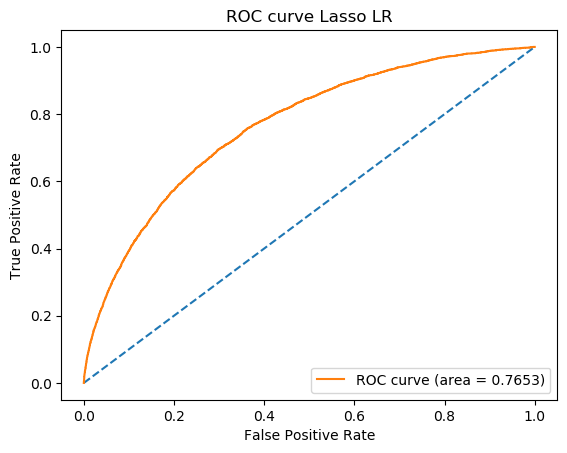

In [152]:
plt_roc(lasso_clf1, 'Lasso LR', png='ROC_l1LR_1.png')

##### Confusion Matrix

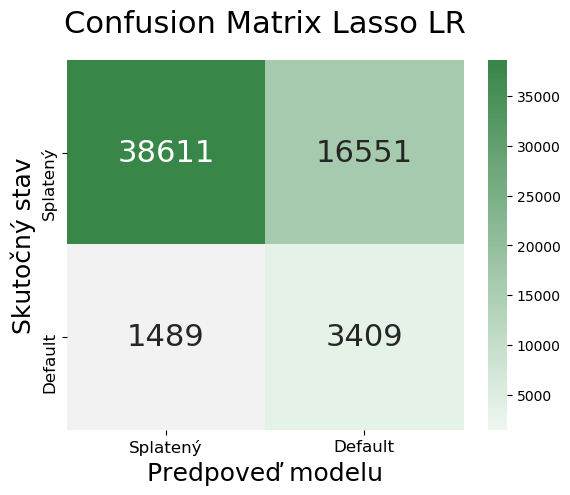

In [153]:
plt_conf(loaded_lasso_clf1, 'Lasso LR', png='CM_l1LR_1.png')

##### Other Metrics

In [83]:
confusion(loaded_lasso_clf1)

False positive rate is 0.30004350821217507
False negative rate is 0.30400163331972235
True negative rate is 0.6999564917878249
True positive rate is 0.6959983666802777
False discovery rate is 0.8292084168336673
Negative predictive value is 0.9628678304239402
Rejection rate 0.33233433233433235


In [84]:
metrics(loaded_lasso_clf1)

Acc 0.6996336996336996
F1 0.2742778984632714
F2 0.4309516585760518
C-kappa 0.16490964707421674
matthews 0.23005019928499532


In [85]:
lasso_1 = LogisticRegression(penalty='l1', C=0.1, solver='saga')
lasso_1.fit(X_train_1,y_train_1)

brier_score_loss(y_test_1, lasso_1.predict_proba(X_test_1)[:,1])

0.06794011012103796

##### Rentability (managerial point of view)

In [92]:
test_credit = application.loc[X_test.index, ['AMT_CREDIT', 'TARGET']]
test_credit['Pred'] = loaded_lasso_clf1.predict(X_test_1)
print(test_credit.groupby('TARGET').sum().iloc[1,0]/test_credit.groupby('TARGET').sum().iloc[0,0])
print(test_credit[test_credit.Pred==0].groupby('TARGET').sum().iloc[1,0]/test_credit[test_credit.Pred==0].groupby('TARGET').sum().iloc[0,0])

test_credit[test_credit.Pred==0].groupby('TARGET').sum()

0.08191553464739985
0.03794121247104655


,AMT_CREDIT,Pred
TARGET,,
0,2.341228e+10,0.0
1,8.882901e+08,0.0


### B) 04. Elastic-net Regularization

##### Training

In [93]:
from sklearn.model_selection import GridSearchCV
el1 = LogisticRegression(penalty='elasticnet', solver='saga', class_weight='balanced')

parameters = {'l1_ratio':[0.6,0.5,0.4], 'C':[0.1,0.01,0.005]}

el_clf1 = GridSearchCV(el1, parameters, cv=3, scoring='roc_auc')
el_clf1.fit(X_train_1, y_train_1)

print('acc:' ,accuracy_score(y_test_1, el_clf1.predict(X_test_1)))

# time

acc: 0.6996170496170496


In [163]:
el_clf1.predict(X_test_1)

array([1., 0., 0., ..., 0., 0., 1.])

##### Storing the model

In [95]:
import pickle

filename = 'el_clf1.sav'
pickle.dump(el_clf1, open(filename, 'wb'))

##### Loading

In [96]:
filename = 'el_clf1.sav'
loaded_el_clf1 = pickle.load(open(filename, 'rb'))

In [97]:
loaded_el_clf1.best_estimator_

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=0.6,
                   max_iter=100, multi_class='auto', n_jobs=None,
                   penalty='elasticnet', random_state=None, solver='saga',
                   tol=0.0001, verbose=0, warm_start=False)

##### Confusion Matrix

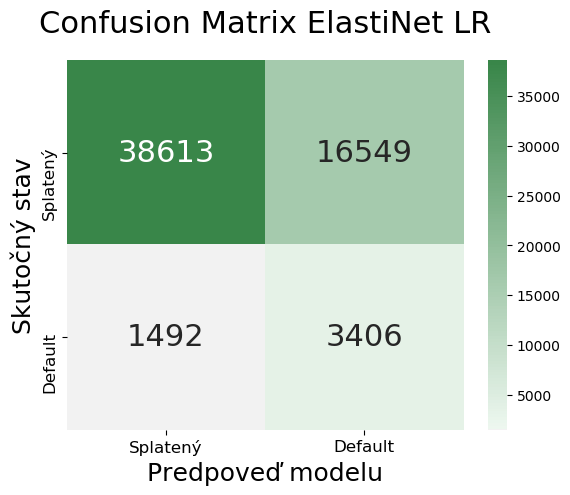

In [154]:
plt_conf(loaded_el_clf1,'ElastiNet LR', png='CM_elLR_1.png')

##### ROC curve

AUC: 0.765


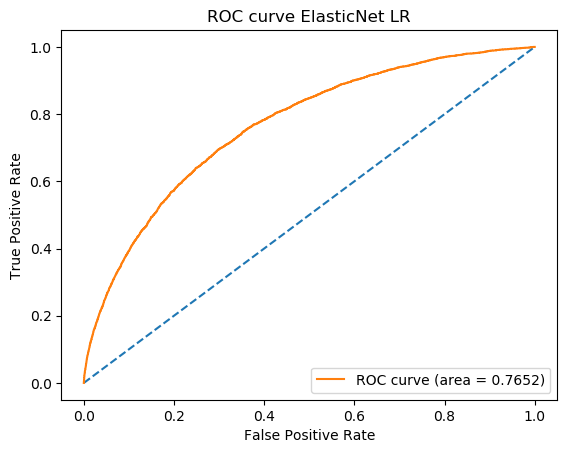

In [155]:
plt_roc(loaded_el_clf1, 'ElasticNet LR', png='ROC_elLR_1.png')

##### Other Metrics

In [100]:
confusion(loaded_el_clf1)

False positive rate is 0.3000072513686958
False negative rate is 0.3046141282155982
True negative rate is 0.6999927486313041
True positive rate is 0.6953858717844018
False discovery rate is 0.8293159609120521
Negative predictive value is 0.9627976561525994
Rejection rate 0.33225108225108224


In [101]:
metrics(loaded_el_clf1)

Acc 0.6996170496170496
F1 0.2740916589546533
F2 0.43062684906566867
C-kappa 0.16470155535957653
matthews 0.22972985986797037


In [104]:
el_1 = LogisticRegression(penalty='elasticnet', C=0.1, l1_ratio=0.6 , solver='saga')
el_1.fit(X_train_1,y_train_1)

brier_score_loss(y_test_1, el_1.predict_proba(X_test_1)[:,1])

0.06793888103324966

##### Rentability (managerial point of view)

In [103]:
test_credit = application.loc[X_test.index, ['AMT_CREDIT', 'TARGET']]
test_credit['Pred'] = loaded_el_clf1.predict(X_test_1)
print(test_credit.groupby('TARGET').sum().iloc[1,0]/test_credit.groupby('TARGET').sum().iloc[0,0])
print(test_credit[test_credit.Pred==0].groupby('TARGET').sum().iloc[1,0]/test_credit[test_credit.Pred==0].groupby('TARGET').sum().iloc[0,0])

test_credit[test_credit.Pred==0].groupby('TARGET').sum()

0.08191553464739985
0.03803998641984775


,AMT_CREDIT,Pred
TARGET,,
0,2.341774e+10,0.0
1,8.908104e+08,0.0


### B) 05. SVM non-regularized

##### Training

In [116]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

svc_base = LinearSVC(dual=False)
nreg_svc1 = CalibratedClassifierCV(base_estimator=svc_base, cv=3)
nreg_svc1.fit(X_train_1, y_train_1)

#3m 3s

CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                loss='squared_hinge',
                                                max_iter=1000,
                                                multi_class='ovr', penalty='l2',
                                                random_state=None, tol=0.0001,
                                                verbose=0),
                       cv=3, method='sigmoid')

In [164]:
nreg_svc1.predict(X_test_1)

array([0., 0., 0., ..., 0., 0., 0.])

##### Saving the model

In [117]:
import pickle

filename = 'non_reg_svc1.sav'
pickle.dump(nreg_svc1, open(filename, 'wb'))

##### Loading model

In [118]:
filename = 'non_reg_svc1.sav'
loaded_nreg_svc1 = pickle.load(open(filename, 'rb'))

##### Kolmogorov–Smirnov test

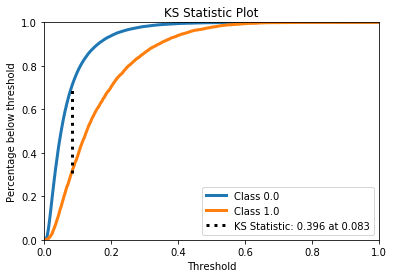

In [66]:
from scikitplot.metrics import plot_ks_statistic
fig, ax = plt.subplots()
y_probas = loaded_nreg_svc1.predict_proba(X_test_1)
plot_ks_statistic(y_test_1, y_probas, ax=ax)

In [119]:
# with new threshold
threshold = 0.083
y_pred_threshold_11 = (loaded_nreg_svc1.predict_proba(X_test_1)[:, 1] >= threshold).astype(bool)

confusion_matrix(y_test_1, y_pred_threshold_11)

array([[38993, 16169],
       [ 1545,  3353]], dtype=int64)

##### ROC curve

AUC: 0.7644


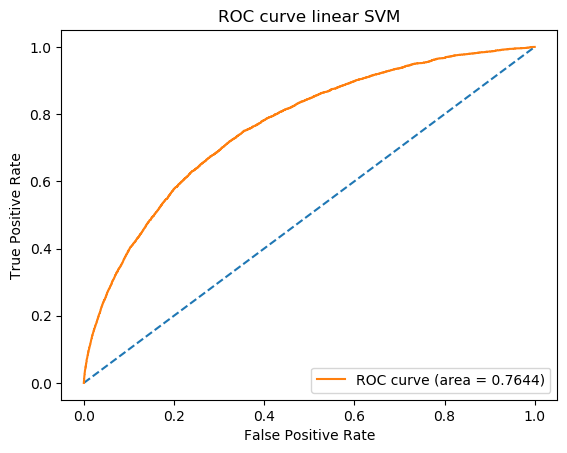

In [157]:
probs = loaded_nreg_svc1.predict_proba(X_test_1)[:, 1]
# positive outcome only

auc = roc_auc_score(y_test_1, probs)
print('AUC: %.4f' % auc)

fpr, tpr, thresholds = roc_curve(y_test_1, probs)

plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, linestyle='-', label='ROC curve (area = %0.4f)' % auc)
plt.legend(loc="lower right")
# labels for axis
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve linear SVM')

plt.savefig('ROC_nonreg_SVC_1.png')
# show the plot
plt.show()

##### Confusion Matrix

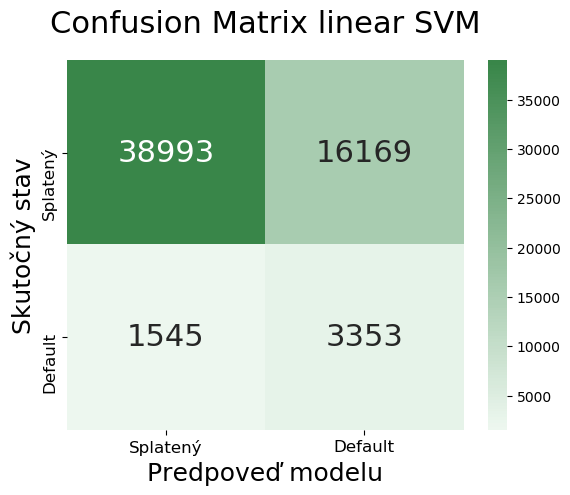

In [156]:
cm = confusion_matrix(y_test_1, y_pred_threshold_11)
ax= plt.subplot()
annot_kws = {"ha": 'center', "va": 'center', 'ma': 'center', 'fontsize':22}
cmap = sns.diverging_palette(10, 133, as_cmap=True)
sns.heatmap(cm,center=0, annot=True, fmt='.0f', annot_kws=annot_kws, xticklabels=['Splatený', 'Default'], yticklabels=['Splatený', 'Default'], cmap=cmap)
# bottom, top = ax.get_ylim()
#ax.set_ylim(bottom + 0.5, top - 0.5)
# labels, title and ticks
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_xlabel('Predpoveď modelu', fontsize=18)
ax.set_ylabel('Skutočný stav', fontsize=18)
ax.set_title('Confusion Matrix linear SVM', fontsize=22, pad=20)


# SAVE
plt.savefig('CM_nonreg_SVM_lin_1.png', bbox_inches='tight')
plt.show()

##### Other Metrics

In [122]:
tn, fp, fn, tp = confusion_matrix(y_test_1, y_pred_threshold_11).ravel()
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (tp + fn)
true_negative_rate = tn / (tn + fp)
negative_predictive_value = tn/ (tn + fn)
false_discovery_rate = fp/ (tp + fp)
true_positive_rate = tp / (tp + fn)

print('False positive rate is', false_positive_rate)
print('False negative rate is', false_negative_rate)
print('True negative rate is', true_negative_rate)
print('True positive rate is', true_positive_rate)
print('False discovery rate is', false_discovery_rate)
print('Negative predictive value is', negative_predictive_value)

rejection_rate = (tp+fp) / (tn + fp + fn + tp)
print('Rejection rate', rejection_rate )

False positive rate is 0.29311845110764656
False negative rate is 0.31543487137607185
True negative rate is 0.7068815488923534
True positive rate is 0.6845651286239282
False discovery rate is 0.8282450568589284
Negative predictive value is 0.9618876116236618
Rejection rate 0.32504162504162504


In [124]:
print('Acc',accuracy_score(y_test, y_pred_threshold_11))
print('F1',f1_score(y_test, y_pred_threshold_11))
print('F2',fbeta_score(y_test, y_pred_threshold_11, beta=2))
print('BS',brier_score_loss(y_test, loaded_nreg_svc1.predict_proba(X_test_1)[:,1]))
print('C-kappa',cohen_kappa_score(y_test, y_pred_threshold_11))
print('matthews',matthews_corrcoef(y_test, y_pred_threshold_11))

Acc 0.7050616050616051
F1 0.2746109746109746
F2 0.4286189088305978
BS 0.06801353952864081
C-kappa 0.16584620985584242
matthews 0.22872239513751727


##### Rentability (managerial point of view)

In [125]:
test_credit = application.loc[X_test.index, ['AMT_CREDIT', 'TARGET']].copy()
test_credit['Pred'] = y_pred_threshold_11
print(test_credit.groupby('TARGET').sum().iloc[1,0]/test_credit.groupby('TARGET').sum().iloc[0,0])
print(test_credit[test_credit.Pred==0].groupby('TARGET').sum().iloc[1,0]/test_credit[test_credit.Pred==0].groupby('TARGET').sum().iloc[0,0])

test_credit[test_credit.Pred==0].groupby('TARGET').sum()

0.08191553464739985
0.039071417848430004


,AMT_CREDIT,Pred
TARGET,,
0,2.372553e+10,False
1,9.269900e+08,False


### B) 06. SVM regularized

##### Training

In [127]:
from sklearn.model_selection import GridSearchCV
svc_base = LinearSVC(class_weight='balanced')

# 'loss':['hinge','squared_hinge'], 
parameters = {'penalty':['l1','l2'], 'C':[0.1,0.01,0.005]}

svc_lin1 = GridSearchCV(svc_base, parameters, cv=3, scoring='f1_weighted')
svc_lin1.fit(X_train_1, y_train_1)

print('acc:' ,accuracy_score(y_test_1, svc_lin1.predict(X_test_1)))

acc: 0.7006327006327007


In [165]:
svc_lin1.predict(X_test_1)

array([1., 0., 0., ..., 0., 0., 1.])

##### Storing model

In [128]:
import pickle

filename = 'svc_linear1.sav'
pickle.dump(svc_lin1, open(filename, 'wb'))

##### Loading

In [129]:
filename = 'models\svc_linear1.sav'
loaded_svc1 = pickle.load(open(filename, 'rb'))

In [130]:
loaded_svc1.best_estimator_

LinearSVC(C=0.01, class_weight='balanced', dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

##### Calibrating

In [133]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

svc_base = LinearSVC(C=0.01, penalty='l2', class_weight='balanced', dual=False)
c_svc1 = CalibratedClassifierCV(base_estimator=svc_base, cv=3)
c_svc1.fit(X_train_1, y_train_1)

CalibratedClassifierCV(base_estimator=LinearSVC(C=0.01, class_weight='balanced',
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                loss='squared_hinge',
                                                max_iter=1000,
                                                multi_class='ovr', penalty='l2',
                                                random_state=None, tol=0.0001,
                                                verbose=0),
                       cv=3, method='sigmoid')

In [134]:
filename = 'calibrated_svc1.sav'
pickle.dump(c_svc1, open(filename, 'wb'))

In [135]:
filename = 'models\calibrated_svc1.sav'
loaded_svc1 = pickle.load(open(filename, 'rb'))

AUC: 0.765


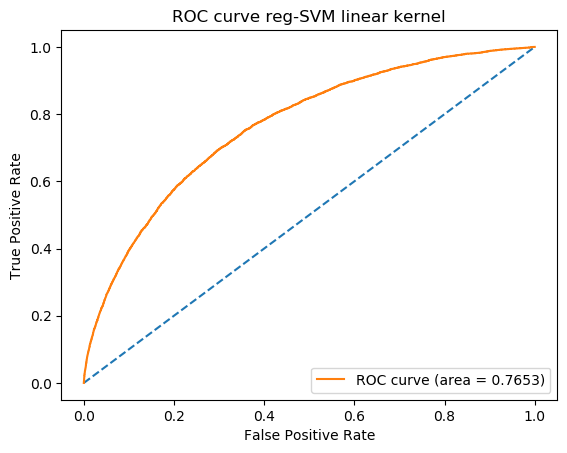

In [158]:
plt_roc(loaded_svc1, name='reg-SVM linear kernel', png='ROC_SVM_Lin1.png')

##### Kolmogorov–Smirnov test

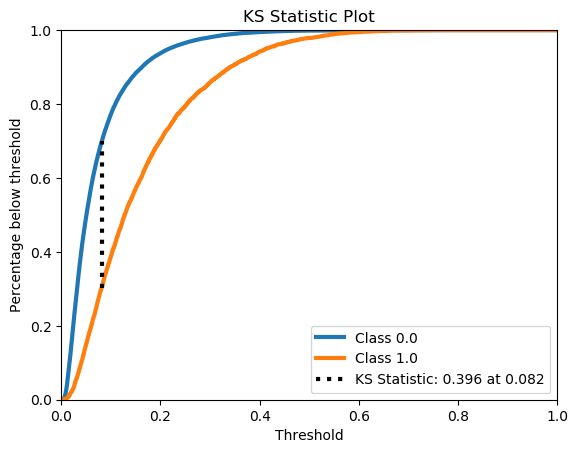

In [138]:
from scikitplot.metrics import plot_ks_statistic
fig, ax = plt.subplots()
y_probas = loaded_svc1.predict_proba(X_test_1)
plot_ks_statistic(y_test_1, y_probas, ax=ax)

In [140]:
# with new threshold
threshold = 0.082
y_pred_threshold_12 = (loaded_svc1.predict_proba(X_test_1)[:, 1] >= threshold).astype(bool)

confusion_matrix(y_test_1, y_pred_threshold_12)

array([[38640, 16522],
       [ 1494,  3404]], dtype=int64)

##### ROC curve

AUC: 0.7653


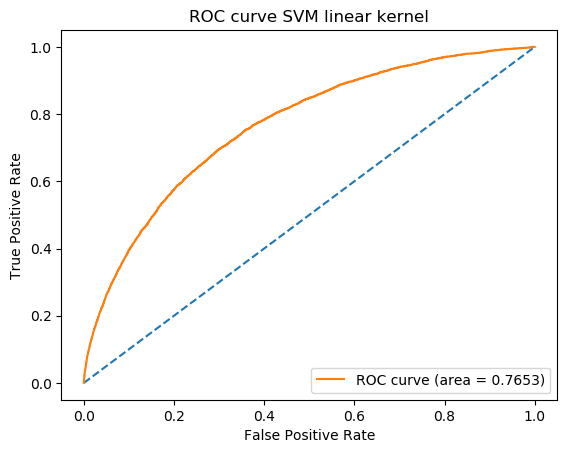

In [141]:
probs = loaded_svc1.predict_proba(X_test_1)[:, 1]
# positive outcome only

auc = roc_auc_score(y_test_1, probs)
print('AUC: %.4f' % auc)

fpr, tpr, thresholds = roc_curve(y_test_1, probs)

plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, linestyle='-', label='ROC curve (area = %0.4f)' % auc)
plt.legend(loc="lower right")
# labels for axis
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve SVM linear kernel')
# show the plot
plt.show()

##### Confusion Matrix

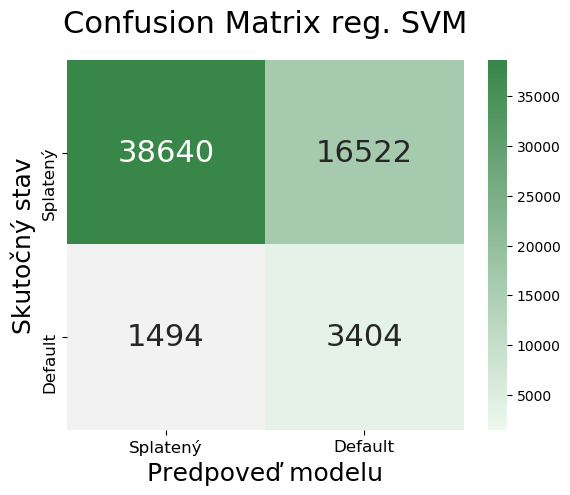

In [159]:
cm = confusion_matrix(y_test_1, y_pred_threshold_12)
ax= plt.subplot()
annot_kws = {"ha": 'center', "va": 'center', 'ma': 'center', 'fontsize':22}
cmap = sns.diverging_palette(10, 133, as_cmap=True)
sns.heatmap(cm,center=0, annot=True, fmt='.0f', annot_kws=annot_kws, xticklabels=['Splatený', 'Default'], yticklabels=['Splatený', 'Default'], cmap=cmap)
# bottom, top = ax.get_ylim()
#ax.set_ylim(bottom + 0.5, top - 0.5)
# labels, title and ticks
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_xlabel('Predpoveď modelu', fontsize=18)
ax.set_ylabel('Skutočný stav', fontsize=18)
ax.set_title('Confusion Matrix reg. SVM', fontsize=22, pad=20)

# SAVE
plt.savefig('CM_SVM_lin1.png', bbox_inches='tight')
plt.show()

##### Other Metrics

In [143]:
tn, fp, fn, tp = confusion_matrix(y_test_1, y_pred_threshold_12).ravel()
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (tp + fn)
true_negative_rate = tn / (tn + fp)
negative_predictive_value = tn/ (tn + fn)
false_discovery_rate = fp/ (tp + fp)
true_positive_rate = tp / (tp + fn)
rejection_rate = (tp+fp) / (tn + fp + fn + tp)

print('False positive rate is', false_positive_rate)
print('False negative rate is', false_negative_rate)
print('True negative rate is', true_negative_rate)
print('True positive rate is', true_positive_rate)
print('False discovery rate is', false_discovery_rate)
print('Negative predictive value is', negative_predictive_value)
print('Rejection rate', rejection_rate )

False positive rate is 0.29951778398172657
False negative rate is 0.3050224581461821
True negative rate is 0.7004822160182734
True positive rate is 0.6949775418538179
False discovery rate is 0.8291679213088428
Negative predictive value is 0.962774704739124
Rejection rate 0.3317682317682318


In [144]:
print('Acc',accuracy_score(y_test, y_pred_threshold_12))
print('F1',f1_score(y_test, y_pred_threshold_12))
print('F2',fbeta_score(y_test, y_pred_threshold_12, beta=2))
print('BS',brier_score_loss(y_test, loaded_svc1.predict_proba(X_test_1)[:,1]))
print('C-kappa',cohen_kappa_score(y_test, y_pred_threshold_12))
print('matthews',matthews_corrcoef(y_test, y_pred_threshold_12))

Acc 0.7000333000333
F1 0.27425072510473736
F2 0.43068981223746133
BS 0.06798178869240606
C-kappa 0.16492067605487504
matthews 0.2298610585232043


##### Rentability (managerial point of view)

In [145]:
test_credit = application.loc[X_test.index, ['AMT_CREDIT', 'TARGET']].copy()
test_credit['Pred'] = y_pred_threshold_12
print(test_credit.groupby('TARGET').sum().iloc[1,0]/test_credit.groupby('TARGET').sum().iloc[0,0])
print(test_credit[test_credit.Pred==0].groupby('TARGET').sum().iloc[1,0]/test_credit[test_credit.Pred==0].groupby('TARGET').sum().iloc[0,0])

test_credit[test_credit.Pred==0].groupby('TARGET').sum()

0.08191553464739985
0.038053648924413146


,AMT_CREDIT,Pred
TARGET,,
0,2.344847e+10,False
1,8.922998e+08,False
